# Import the libraries that are needed

In [5]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
import sklearn
from sklearn import preprocessing
import scipy as sc
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

TensorFlow version: 2.9.2


#initialize the train and test data set + perform the fourier transformation

making the grids

In [6]:
modinfo = np.loadtxt('modinfo.csv',dtype=float,delimiter=',')

In [7]:
allegrids = []
for ii in range(len(modinfo)):
  grid = np.zeros((200,200))
  for kk in range(np.int(np.round(modinfo[ii,0]))):
      for jj in range(200):
        grid[kk,jj] = modinfo[ii,2]

  for kk in range(np.int(np.round(modinfo[ii,0])),200):
    for jj in range(200):
      grid[kk,jj] = modinfo[ii,3]

  tanding = np.abs(np.round(np.tan(np.deg2rad(modinfo[ii,1])) * 200/2))
  for mm in range(100,200):
    for kk in range(max(0,np.int(-(mm-100)*tanding/100 + np.int(np.round(modinfo[ii,0])))),np.int(np.round(modinfo[ii,0]))):
      grid[kk,mm] =  modinfo[ii,3]

  for mm in range(0,100):
    for kk in range(np.int(np.round(modinfo[ii,0])),min(200,np.int(-(mm-100)*tanding/100 + np.int(np.round(modinfo[ii,0]))))):
      grid[kk,mm] =  modinfo[ii,2]
  allegrids.append(grid)
#reduce dimension (for minimal RAM usage)
herschaalmod = Sequential()
herschaalmod.add(MaxPooling2D(3, 3))
herschaalmod.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
X = np.array(allegrids).reshape(len(allegrids), 200,200,1)
kleinegrids = herschaalmod.predict(X)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note lin

230/230 [==============================] - 6s 24ms/step


In [8]:
targetdata = np.loadtxt('verschilgeschaald.csv',dtype=float,delimiter=',') #data that we want to predict
dim_targetdata = 99 #number of values that need to be predicted per input point
modinfo = np.loadtxt('modinfo.csv',dtype=float,delimiter=',') 
alleLFs = np.loadtxt('alleLFs.csv',dtype=float,delimiter=',') 
features = []
for ii in range(len(modinfo)): 
    rij = modinfo[ii]
    toetevoegen = np.concatenate([rij, alleLFs[ii]])
    features.append(toetevoegen)
features = np.array(features) #input data for the model
dim_modinfo = 4+99 #number of input parameters per input point
train_size = 6300 #number of datapoints in the train dataset
test_size = 1000 #number of datapoints in the test dataset
dim_latent_space = 5 #dimension of the latent space representation
num_feature_maps = 9 #number of feature maps in the convolutional layer used to predict the parameters (optimization might yield different parameters for the fouriercomponents and the hidden states but that is not taken into account here)
kernel_size = 6 #dimension of the kernel in the convolutional layer used to predict the parameters(kernel_size x kernel_size) (optimization might yield different parameters for the fouriercomponents and the hidden states but that is not taken into account here)
dense_layer_size = 2048 #number of units for the dense layer (optimization might yield different parameters for the fouriercomponents and the hidden states but that is not taken into account here)
grids = kleinegrids #input figures
dimgrids = 66 #dimensionality of the grids

In [9]:
#perform the fourier transform
verschilfour = []
for ii in range(len(targetdata)):
  verschilfour.append(sc.fft.fft(targetdata[ii]))
verschilfour = np.array(verschilfour)
#split in real and imaginary part
re = np.real(verschilfour)
im = np.imag(verschilfour)
topred = []
for ii in range(len(re)):
  tijdsding = []
  for jj in range(len(re[0])):
    elnt = [re[ii,jj],im[ii,jj]]
    tijdsding.append(elnt)
  topred.append(tijdsding)
topred = np.array(topred)

indexen = range(len(verschilfour))

#split in train and test data set
X_trainges, X_testges, indexen_trainges_final, indexen_testges_final = train_test_split(features, indexen, train_size=train_size, test_size=test_size, random_state=333)
training_yges = topred[indexen_trainges_final]
y_testges = topred[indexen_testges_final]

Exploit symmetry of the fouriertransform

In [10]:
redeel = (topred[:,:,0]).copy()
for ii in range(int((dim_targetdata-1)/2),dim_targetdata):
  redeel[:,ii] = topred[:,int((dim_targetdata+1)/2-abs((dim_targetdata-1)/2-ii)),0]

In [11]:
imdeel = (topred[:,:,1]).copy()
for ii in range(int((dim_targetdata-1)/2),dim_targetdata):
  imdeel[:,ii] = -topred[:,int((dim_targetdata+1)/2-abs((dim_targetdata-1)/2-ii)),1]

# Define the fouriercomponents that will be used for the prediction

In [12]:
relim = [5,95,99] #[x,y,z]: fouriercomponents from 0 to x and from y to z are taken into account for the real part with the last ones mirrored from the first ones
imlim = [4,96,99] #[x,y,z]: fouriercomponents from 0 to x and from y to z are taken into account for the imag part with the last ones mirrored from the first ones

In [13]:
predfour = topred.copy()
for jj in range(len(predfour)):
  for ii in range(imlim[0],imlim[1]):
    predfour[jj][ii][1] = 0
  for ii in range(relim[0],relim[1]):
    predfour[jj][ii][0] = 0
  for ii in range(imlim[1],imlim[2]):
    predfour[jj][ii][1] = -topred[jj,np.int((dim_targetdata+1)/2-abs((dim_targetdata-1)/2-ii)),1]
  for ii in range(relim[1],relim[2]):
    predfour[jj][ii][0] = topred[jj,np.int((dim_targetdata+1)/2-abs((dim_targetdata-1)/2-ii)),0]  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprec

Prediction based on the limited number of fourier components

In [14]:
pred = []
for ii in range(len(predfour)):
  tijdsvector = []
  for jj in range(len(predfour[0])):
    tijdsvector.append(complex(predfour[ii,jj,0],predfour[ii,jj,1]))
  pred.append(tijdsvector)
predictie = np.real(sc.fft.ifft(pred))

# Use neural network to estimate the difference between the fourierprediction and the real values

In [15]:
errfour = []
for ii in range(len(targetdata)):
  errfour.append(targetdata[ii]-predictie[ii])

split in train and test dataset

In [16]:
indexenfourr = range(len(errfour))
errfour_train, errfour_test, indexen_trainges, indexen_testges = train_test_split(errfour, indexenfourr, train_size=train_size, test_size=test_size, random_state=333)

make and train the neural network

In [19]:
X = np.array(errfour_train).reshape(len(errfour_train), dim_targetdata)
params_input = keras.Input(shape=(dim_targetdata))
encoder = tf.keras.layers.Dense(dim_latent_space,activation = 'tanh')(params_input)
decoder = tf.keras.layers.Dense(dim_targetdata)(encoder)
modelauto = keras.Model(inputs=params_input,outputs=decoder)
modelauto.compile(optimizer='adam', loss='mse')
modelauto.summary()
hist = modelauto.fit(X,X,epochs=500,validation_split=0.2,batch_size=32)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 99)]              0         
                                                                 
 dense_2 (Dense)             (None, 5)                 500       
                                                                 
 dense_3 (Dense)             (None, 99)                594       
                                                                 
Total params: 1,094
Trainable params: 1,094
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
158/158 [==============================] - 2s 8ms/step - loss: 4.1109 - val_loss: 0.0012
Epoch 2/500
158/158 [==============================] - 0s 2ms/step - loss: 4.1089 - val_loss: 0.0012
Epoch 3/500
158/158 [==============================] - 0s 2ms/step - loss: 4.1073 - val_loss: 0.0012
Epoch 4/500
158/15

Prediction based on limited number of fourier components and predicted difference

In [20]:
test_input = np.array(errfour).reshape(len(errfour), dim_targetdata)
test_output = np.array(modelauto.predict(test_input, verbose=0)) # = echt - fourier

In [21]:
uiteindelijkeschatting = test_output + predictie

# Prediction of the parameters

In [23]:
fourtopred = np.concatenate([predfour[:,0:5,0],predfour[:,1:4,1]],axis = 1) # 1:4 because first one is always 0
#obtain the hidden vectors
Xen = np.array(errfour).reshape(len(errfour), dim_targetdata)
layer_output = modelauto.get_layer('dense_2').output #dense can need an extra number, depending on how much the algorithm is performed
intermediate_model=tf.keras.models.Model(inputs=params_input,outputs=layer_output)
tussen=intermediate_model.predict(Xen) # = hidden vectors!
tevoorspellen = np.concatenate([fourtopred,tussen],axis = 1)

230/230 [==============================] - 0s 948us/step


In [24]:
indexen = range(len(features))
X_train_four, X_test_four, indexen_train_four, indexen_test_four = train_test_split(grids, indexen, train_size=train_size, test_size=test_size, random_state=333)
training_y_four = fourtopred[indexen_train_four]
y_test_four = fourtopred[indexen_test_four]

X = np.array(X_train_four).reshape(len(X_train_four), dimgrids,dimgrids,1)

Y = np.array(training_y_four).reshape(len(training_y_four), 8)
#using a standardscaler here is advised

Make and train the neural network

In [26]:
modelsfour = Sequential()
modelsfour.add(Conv2D(num_feature_maps,kernel_size=kernel_size,activation='relu',input_shape=(dimgrids, dimgrids, 1)))
modelsfour.add(MaxPooling2D(2, 2))
modelsfour.add(Flatten())
modelsfour.add(Dense(dense_layer_size, activation='relu'))
modelsfour.add(Dropout(0.2))
modelsfour.add(Dense(8))
modelsfour.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
modelsfour.summary()
hist = modelsfour.fit(X,Y,epochs=100,validation_split=0.2,batch_size=32) 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 61, 61, 9)         333       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 9)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 8100)              0         
                                                                 
 dense_6 (Dense)             (None, 2048)              16590848  
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_7 (Dense)             (None, 8)                 16392     
                                                      

In [27]:
test_input = np.array(grids).reshape(len(grids), dimgrids,dimgrids,1)
test_output = np.array(modelsfour.predict(test_input, verbose=0))
fourpredictienn = np.vstack(np.transpose(np.array((test_output[:,0],test_output[:,1],test_output[:,2],test_output[:,3],test_output[:,4],np.zeros(len(test_output)),test_output[:,5],test_output[:,6],test_output[:,7]))))

##Predict the hidden state

In [28]:
indexen = range(len(features))
feathid = []
#add the predicted fouriercomponents to the input of hiddenstate prediction
for ii in range(len(features)):
  feathid.append(np.concatenate([features[ii], fourpredictienn[ii]]))


X_train_hid, X_test_hid, indexen_train_hid, indexen_test_hid = train_test_split(grids, indexen, train_size= train_size, test_size=test_size, random_state=333)
training_y_hid = tussen[indexen_train_hid]
y_test_hid = tussen[indexen_test_hid]
X2_train = fourpredictienn[indexen_train_hid]
X2_test = fourpredictienn[indexen_test_hid]

X1 = np.array(X_train_hid).reshape(len(X_train_hid), dimgrids,dimgrids,1)
X2 = np.array(X2_train).reshape(len(X2_train),9)

Y = np.array(training_y_hid).reshape(len(training_y_hid), 5)
#again it's better to standardscale

In [29]:
inp1 = keras.Input(shape=(dimgrids,dimgrids,1))
inp2 = keras.Input(shape=(9))
convlayer = Conv2D(num_feature_maps,kernel_size=kernel_size,activation='relu',input_shape=(dimgrids, dimgrids, 1))(inp1)
maxpool = MaxPooling2D(2,2)(convlayer)
flatlay = Flatten()(maxpool)
denselay = Dense(dense_layer_size, activation='relu')(flatlay)
droplay = Dropout(0.2)(denselay)
conclay = layers.concatenate([droplay,inp2])
denselas = (Dense(5))(conclay)
modelhid = keras.Model(inputs=(inp1,inp2),outputs=denselas)
modelhid.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
modelhid.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 66, 66, 1)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 61, 61, 9)    333         ['input_3[0][0]']                
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 30, 30, 9)   0           ['conv2d_2[0][0]']               
                                                                                                  
 flatten_2 (Flatten)            (None, 8100)         0           ['max_pooling2d_3[0][0]']        
                                                                                            

In [31]:
hist = modelhid.fit((X1,X2),Y,epochs=100,validation_split=0.2,batch_size=32)

Epoch 1/100
158/158 [==============================] - 34s 213ms/step - loss: 2.4121 - accuracy: 0.9974 - val_loss: 0.0074 - val_accuracy: 0.9960
Epoch 2/100
158/158 [==============================] - 34s 217ms/step - loss: 2.7705 - accuracy: 0.9968 - val_loss: 0.0076 - val_accuracy: 0.9968
Epoch 3/100
158/158 [==============================] - 34s 217ms/step - loss: 2.6302 - accuracy: 0.9978 - val_loss: 0.0115 - val_accuracy: 0.9976
Epoch 4/100
158/158 [==============================] - 34s 217ms/step - loss: 2.2972 - accuracy: 0.9958 - val_loss: 0.0070 - val_accuracy: 0.9952
Epoch 5/100
158/158 [==============================] - 33s 210ms/step - loss: 1.9397 - accuracy: 0.9974 - val_loss: 0.0082 - val_accuracy: 0.9968
Epoch 6/100
158/158 [==============================] - 34s 216ms/step - loss: 1.8196 - accuracy: 0.9972 - val_loss: 0.0054 - val_accuracy: 0.9960
Epoch 7/100
158/158 [==============================] - 34s 216ms/step - loss: 1.5437 - accuracy: 0.9988 - val_loss: 0.0063 -

In [32]:
xtetest = grids
x2tetest = fourpredictienn
test_input = np.array(xtetest).reshape(len(xtetest), dimgrids,dimgrids,1)
test2_input = np.array(x2tetest).reshape(len(x2tetest),9)
test_output = np.array(modelhid.predict((test_input,test2_input), verbose=0))
hidpredictienn = (test_output)

# From estimated parameters back to prediction

In [33]:
fourpred = fourpredictienn
hiddenpred = hidpredictienn

In [34]:
allefourpredtussen = []
for jj in range(len(topred)):
  toetevoegen = np.zeros((99,2))
  for ii in range(imlim[0],imlim[1]):
    toetevoegen[ii][1] = 0
  for ii in range(relim[0],relim[1]):
    toetevoegen[ii][0] = 0
  for ii in range(0,relim[0]):
    toetevoegen[ii][0] = fourpred[jj,ii]
  for ii in range(0,imlim[0]):
    toetevoegen[ii][1] = fourpred[jj,ii+5]
  allefourpredtussen.append(toetevoegen)

allefourpred = allefourpredtussen.copy()
for jj in range(len(topred)):
  for ii in range(imlim[1],imlim[2]):
    allefourpred[jj][ii][1] = -allefourpredtussen[jj][np.int((dim_targetdata+1)/2-abs((dim_targetdata-1)/2-ii))][1]
  for ii in range(relim[1],relim[2]):
    allefourpred[jj][ii][0] = allefourpredtussen[jj][np.int((dim_targetdata+1)/2-abs((dim_targetdata-1)/2-ii))][0]  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

In [35]:
allefourpredcompl = []
for jj in range(len(allefourpred)):
  tijdsvector = []
  for ii in range(len(allefourpred[0])):
      tijdsvector.append(complex(allefourpred[jj][ii][0],allefourpred[jj][ii][1]))
  allefourpredcompl.append(tijdsvector)

Inverse fouriertransform

In [36]:
tijdslijntjenafour = np.real(sc.fft.ifft(allefourpredcompl))

Adding the auto-encoder

In [38]:
Xen = np.array(hiddenpred).reshape(len(hiddenpred), dim_latent_space)
layer_output = modelauto.get_layer('dense_3').output #last layer
layer_input = modelauto.get_layer('dense_2').output #first dense layer
automoduit =tf.keras.models.Model(inputs=layer_input,outputs=layer_output)
correctiepred=automoduit.predict(Xen) # = hidden vectors!

230/230 [==============================] - 0s 839us/step


In [39]:
finalepred = correctiepred + tijdslijntjenafour

Text(0.5, 0, 'Time')

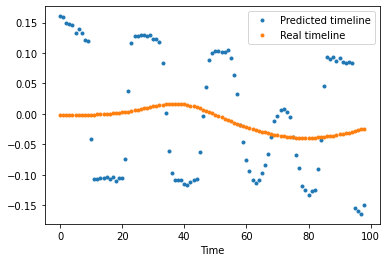

In [51]:
plt.plot(finalepred[900],'.',label='Predicted timeline')
plt.plot(targetdata[900],'.',label='Real timeline')
plt.legend()
plt.xlabel('Time')

Text(0.5, 0, 'Depth')

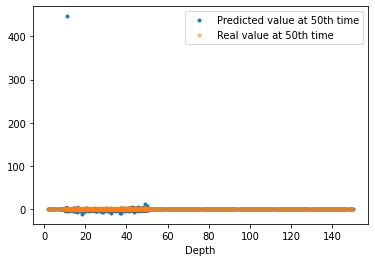

In [53]:
plt.plot(modinfo[:,0],finalepred[:,30],'.',label='Predicted value at 50th time')
plt.plot(modinfo[:,0],targetdata[:,30],'.',alpha=0.5,label='Real value at 50th time')
plt.legend()
plt.xlabel('Depth')